In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from numpy import *
# for finding k eigen values
import scipy.sparse.linalg

In [2]:
def calculateErr(T, Y):
    vT = (T >= 0);
    vY = (Y >= 0);
    err = sum(vT != vY)/size(Y);
    return err


In [3]:
def MixGauss(means, sigmas, n):
    numRowsOfMeans = means.shape[0];
    numColsOfMeans = means.shape[1];
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    
#     X = zeros((200,2))
#     Y = zeros((200,1))
    X = []
    Y = []
    for i in range(numColsOfMeans):
        meansOfColumnI = means[:, i]
        sigmaOfI = sigmas[i]
        Xi = zeros((n, numRowsOfMeans))
        Yi = zeros((n, 1))
        
        for j in range(n):
            x = sigmaOfI * random.randn(numRowsOfMeans, 1) + meansOfColumnI
            Xi[j, :] = squeeze(asarray(x))
            Yi[j] = i+1
            
#         tempXi = Xi
#         tempYi = Yi
            
        X.append(Xi)
        Y.append(Yi)
#         X = column_stack(Xi)
#         X = concatenate((Xi, Xi), axis=0)
#         Y = concatenate((Yi, Yi), axis=0)
#         X[0:100,:] = tempXi
#         X[100:200,:] = Xi
#         Y[0:100,:] = tempYi
#         Y[100:200,:] = Yi
    return X, Y
            

In [4]:
def PCA(X, k):
# [V, d, X_proj] = PCA(X, k)
# computes the first k eigenvectors, eigenvalues and projections of the 
# matrix X'*X/n where n is the number of rows in X.
# 
# X is the dataset
# k is the number of components
# 
# V is a matrix of the form [v_1, ..., v_k] where v_i is the i-th
# eigenvector
# d is the list of the first k eigenvalues
# X_proj is the projection of X on the linear space spanned by the
# eigenvectors in V
    
    numRowsOfX = X.shape[0]
    D, V = scipy.sparse.linalg.eigs((X.conj().transpose().dot(X))/numRowsOfX, k)
#     diagonal = diag(D)
    D = D * (D > 0)
#     D = sorted(D, reverse = True)
    D[::-1].sort()
    I = D.argsort()
    V = V[:, I]
    X_proj = X.dot(V)
    
    return V, D, X_proj

In [5]:
def OMatchingPursuit(inputData, outputLabel, numOfIter):
# X = array([[1.,2.,3.], [4.,5.,6.]])
# row, col = shape(X)
    numOfRow, numOfCol = shape(inputData)
    residual = outputLabel
    estimatedCoeff = zeros((numOfCol, 1))
    indices = []
    
    for i in range(numOfIter):
        indices_tmp = list(range(numOfRow))
        
        ### Select the column of X which most "explains" the residual
        a_max = -1
        
        for j in indices_tmp:
#             a_tmp = ((residual.T * X[:,1])**2)/(X[:,1].T * X[:,1])
            a_tmp = ((residual.T.dot(inputData[:,1]))**2)/(inputData[:,1].T.dot(inputData[:,1]))
            
            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j
                
        # Add the index to the set of indexes
        if sum(indices == j_max) == 0:
            indices.append(j_max)
            
        # Compute the M matrix
        M_I = zeros((numOfCol,numOfCol))
                    
        for j in indices:
            M_I[j,j] = 1
                   
        A = M_I.dot(inputData.T).dot(inputData).dot(M_I)
        B = M_I.dot(inputData.T).dot(outputLabel)
        
        # Update estimated coefficients
        estimatedCoeff = linalg.pinv(A).dot(B)
        
        # Update the residual
        residual = outputLabel - inputData.dot(estimatedCoeff)
        
        return estimatedCoeff, residual, indices
 

In [6]:
def holdoutCVOMP(X, Y, perc, nrip, intIter):
    nIter = size(intIter)
    
    n = X.shape[0]
    ntr = ceil(n*(1-perc))
    
    tmn = zeros((nIter, nrip))
    vmn = zeros((nIter, nrip))
    
    for rip in range(nrip):
        I = random.permutation(n)
        Xtr = X[I[:ntr],:]
        Ytr = Y[I[:ntr],:]
        Xvl = X[I[ntr:],:]
        Yvl = Y[I[ntr:],:]
        
        iit = 0
        
        for it in range(intIter):
            iit = iit + 1;
            w = OMatchingPursuit(Xtr, Ytr, it)
            tmn[iit, rip] =  calcErr(Xtr.dot(w),Ytr)
            vmn[iit, rip]  = calcErr(Xvl.dot(w),Yvl)
            
            print(('rip\\tIter\\tvalErr\\ttrErr\\n%d\\t%d\\t%f\\t%f\\n'), rip, it, vmn(iit, rip), tmn(iit, rip))
            
    Tm = median(tmn,axis=1);
    Ts = std(tmn,axis=1);
    Vm = median(vmn,axis=1);
    Vs = std(vmn,axis=1);
    
    row = nonzero(Vm <= min(min(Vm)));
    
    it = intIter[row[0]]
    
    return it, Vm, Vs, Tm, Ts


In [7]:
def calcErr(T, Y):
    err = mean(sign(T)!=sign(Y));
    return err

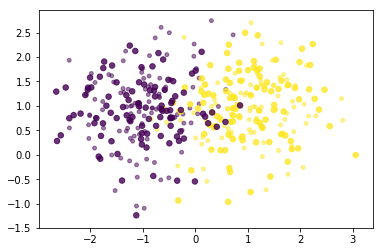

In [14]:
N = 100;
D = 30;
Xtr, Ytr = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7], [0.7]]),N);
Xtr = concatenate(Xtr, axis=0)
Ytr = concatenate(Ytr, axis=0)
Ytr[Ytr==2]= -1;
Xts, Yts = MixGauss(matrix([[1,-1],[1,1]]),array([[0.7],[0.7]]),N);
Xts = concatenate(Xts, axis=0)
Yts = concatenate(Yts, axis=0)
Yts[Yts==2] = -1;

plt.scatter(Xtr[:,0], Xtr[:,1], s=15, c=Ytr, alpha=0.5)
plt.scatter(Xts[:,0], Xts[:,1], s=30, c=Yts, alpha=0.8)
plt.show()

In [15]:
sigma_noise = 0.01;
# Xtr_noise=sigma_noise*randn(2*N,D-2);
# Xts_noise=sigma_noise*randn(2*N,D-2);
Xtr_noise = sigma_noise*random.randn(2*N, D-2);
Xts_noise = sigma_noise*random.randn(2*N, D-2);

# Xtr =[Xtr, Xtr_noise];
# Xts =[Xts, Xts_noise];
Xtr = concatenate((Xtr, Xtr_noise), axis=1)
Xts = concatenate((Xts, Xts_noise), axis=1)

/home/suraj/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


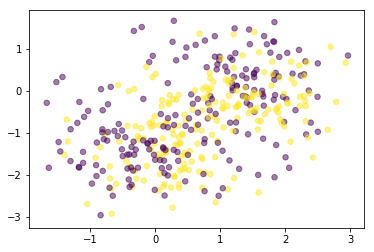

In [17]:
V, d, X_proj = PCA(Xtr, 2)
# scatter(X_proj(:,1), X_proj(:,2), 50, Ytr, 'filled');
plt.scatter(X_proj[:,0], X_proj[:,1], s=30, c=Ytr, alpha=0.5)
plt.show()

In [22]:
V, d, X_proj = PCA(Xtr, 3)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X_proj[:,0], ys=X_proj[:,1], zs=0, c=Ytr, alpha=0.5)
plt.show()

/home/suraj/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/suraj/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


ValueError: Invalid RGBA argument: (0.99324800000000002, 0.90615699999999999, 0.14393600000000001, (0.2759798917347086+0j))

[ 1.23817699+0.j  1.15606610+0.j  0.01357738+0.j  0.01309667+0.j
  0.01284202+0.j  0.01223016+0.j  0.01195091+0.j  0.01175136+0.j
  0.01160013+0.j  0.01158963+0.j]


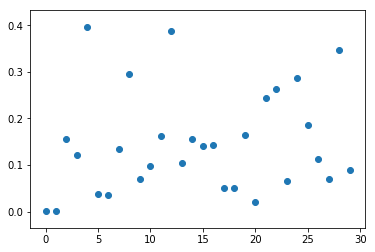

In [44]:
V, d, X_proj = PCA(Xtr, 10);
print(sqrt(d[:10]));
# figure(4)
plt.scatter(list(range(D)), abs(V[:,0]))
plt.show()

In [42]:
V
# d[:10]

array([[ -7.51712322e-04+0.j,  -9.31972730e-04+0.j,   1.72484068e-04+0.j,
          1.77843283e-04+0.j,   3.12082472e-04+0.j,  -9.27085051e-04+0.j,
         -7.09450995e-04+0.j,  -1.74573618e-04+0.j,   5.78444629e-01+0.j,
         -8.15715476e-01+0.j],
       [  2.77488984e-04+0.j,   7.92284838e-05+0.j,  -1.05298587e-05+0.j,
         -1.19558804e-04+0.j,   3.92663931e-05+0.j,  -5.71877377e-05+0.j,
          5.43252311e-05+0.j,  -1.52810112e-04+0.j,  -8.15717471e-01+0.j,
         -5.78445516e-01+0.j],
       [ -7.45468775e-02+0.j,   1.56354909e-01+0.j,   6.62328531e-02+0.j,
         -5.09673388e-02+0.j,   8.43453305e-02+0.j,   8.48446965e-02+0.j,
          8.52116258e-02+0.j,   8.27537171e-03+0.j,  -5.30952879e-04+0.j,
          7.86295832e-05+0.j],
       [ -1.52934832e-01+0.j,  -1.20859340e-01+0.j,  -1.67310803e-02+0.j,
          1.89601210e-03+0.j,  -1.53413882e-01+0.j,  -3.35335112e-01+0.j,
          4.42891721e-01+0.j,   7.51460193e-02+0.j,  -1.65818281e-04+0.j,
          1.4031971

In [35]:
abs(V[:,0])

array([  7.51712322e-04,   2.77488984e-04,   7.45468775e-02,
         1.52934832e-01,   1.73397586e-01,   3.42112901e-01,
         1.02400975e-01,   4.78554066e-02,   1.73142063e-01,
         2.21405194e-01,   4.32626925e-02,   3.32196690e-01,
         1.70644206e-01,   3.25599995e-01,   4.08317744e-01,
         1.23869433e-01,   7.72533812e-02,   9.14317626e-02,
         1.11394718e-01,   1.45409920e-01,   2.03067538e-01,
         1.18610070e-01,   1.25106966e-01,   7.65377266e-02,
         1.55464354e-01,   8.25714917e-03,   1.21332221e-01,
         1.60067675e-01,   1.12368628e-01,   3.17553131e-01])

In [4]:
# Xtr, Ytr = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)

In [5]:
# Xtr = concatenate(Xtr, axis=0)
# Ytr = concatenate(Ytr, axis=0)
# shape(Xtr)

(200, 2)

In [6]:
# Ytr[Ytr==2] = -1

In [7]:
# Xts, Yts = MixGauss(matrix([[1,1],[-1,-1]]), array([[0.7], [0.7]]), 100)
# Xts = concatenate(Xts, axis=0)
# Yts = concatenate(Yts, axis=0)
# shape(Xts)

(200, 2)

In [8]:
Yts[Yts==2] = -1;

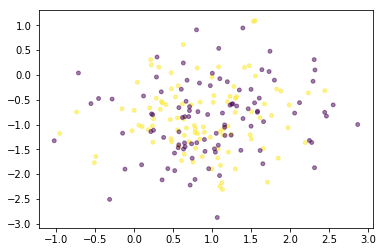

In [9]:
plt.scatter(Xtr[:,0], Xtr[:,1], s=15, c=Ytr, alpha=0.5)
plt.show()

1.C The remaining variables will be generated as gaussian noise

In [10]:
sigma_noise = 0.01;
N = 100
D = 30
Xtr_noise = random.randn(2*N, D-2);
Xts_noise = sigma_noise*random.randn(2*N,D-2);

In [11]:
# Xtr = concatenate(Xtr, Xtr_noise, axis = 1)
shape(Xtr_noise)

(200, 28)

In [12]:
Xtr = concatenate((Xtr, Xtr_noise), axis=1)
Xts = concatenate((Xts, Xts_noise), axis=1)

In [13]:
Xtr.shape

(200, 30)

In [15]:
V, D, X_proj = PCA(Xtr, 2)

In [24]:
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
Axes3D.scatter(xs=X_proj[:,0], ys=X_proj[:,1], zs=0, zdir='z', s=20, c=Ytr, depthshade=True)

TypeError: scatter() missing 1 required positional argument: 'self'

In [23]:
type(2)

int

In [41]:
w, r, I = OMatchingPursuit( Xtr, Ytr, 2)


In [39]:
 w = OMatchingPursuit(Xtr, Ytr, 2)

In [41]:
D, V = scipy.sparse.linalg.eigs((X.conj().transpose().dot(X))/numRowsOfX, k)

NameError: name 'X' is not defined